## Understanding why a Gaussian approximation works well

Testing theory.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT, normal_adjust, uniform_adjust, no_adjust
from scipy.special import erf

gaussian_pdf = lambda x, mu, sigma: (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
gaussian_cdf = lambda x: 0.5 * (erf(x/np.sqrt(2)) + 1)

def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

Already simulated


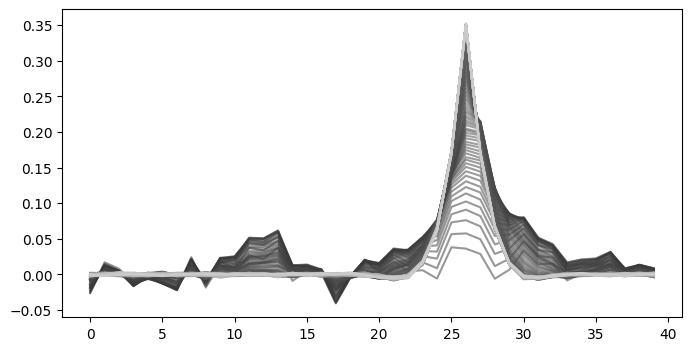

In [2]:
config = dict(
  # data config
  num_dimensions=40,
  xi=(0.1, 3),
  adjust=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu', use_bias=False, batch_size=1000, init_scale=0.01, learning_rate=0.01, evaluation_interval=10,
#   activation='sigmoid', use_bias=True, bias_value=-1, bias_trainable=False, batch_size=1000, init_scale=0.1, learning_rate=0.1, evaluation_interval=10,
  num_hiddens=1,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  optimizer_fn=optax.sgd,
  num_epochs=2000,
  # experiment config
  seed=42,#0,
  save_=True,
)

DRT = build_DRT(config['num_dimensions'])
num_epochs = config['num_epochs']
lr = config['learning_rate']

weights_nlgp, metrics_nlgp = simulate_or_load(**config, gain=100, dataset_cls=datasets.NonlinearGPDataset)
_ = plot_rf_evolution(weights_nlgp[:,:1], figsize=(8, 4))

In [18]:
config = dict(
  # data config
  num_dimensions=40,
  xi=(3, 3),
  # xi=(0.1, 0.1),
  # xi=(15, 15),
  adjust=(-1, 1),
  gain=100, #0.5,
  key=jax.random.PRNGKey(0),
)

dataset = datasets.NonlinearGPDataset(**config)
x = dataset[:50000][0]

In [23]:
ind = 26 # 100
marginal = 1 # 0.1
xfilt = x[(marginal-0.025 < x[:,ind]) & (x[:,ind] < marginal+0.025)]
print(xfilt.shape)

xp = np.linspace(-10, 10, 1000)

Sigma = build_non_gaussian_covariance(config['num_dimensions'], config['xi'][0], config['gain'])
mui = marginal * Sigma[:,ind]
Sigmai = Sigma - jnp.outer(Sigma[:,ind], Sigma[:,ind])

(24747, 40)


In [41]:
perm = np.random.permutation(config['num_dimensions'])
weights = weights_nlgp[:,:,perm]

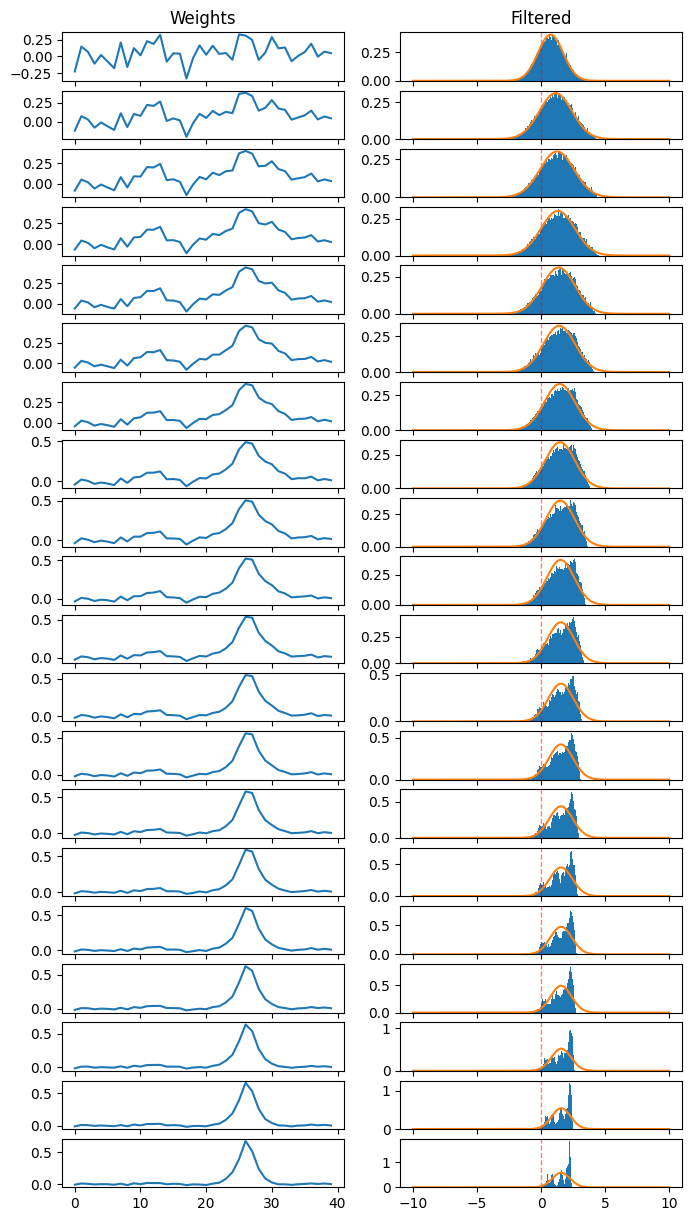

In [42]:
fig, axs = plt.subplots(20, 2, figsize=(8, 15), sharex='col', sharey=False)
for i, (ax1, ax2) in enumerate(axs):
    if i == 0:
        ax1.set_title('Weights')
        ax2.set_title('Filtered')
    
    w = weights_nlgp[2*i,0]
    w /= jnp.linalg.norm(w)
    ax1.plot(w)
    ax2.hist(xfilt @ w, bins=100, density=True)
    ax2.axvline(0, color='r', linestyle='--', linewidth=1, alpha=0.5)

    m = mui @ w
    s = jnp.sqrt(w @ Sigmai @ w)
    ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

0.18415508 1.1183105
0 1.1333717


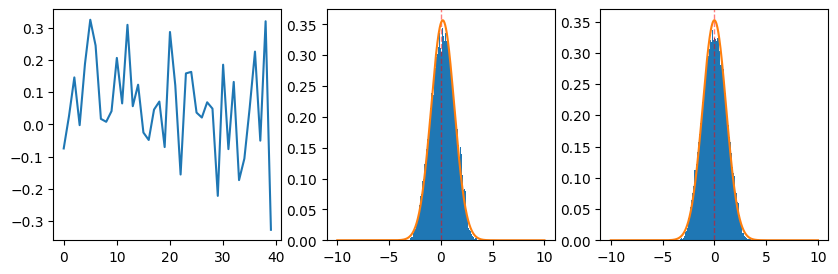

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), sharex='col', sharey=False)
w = weights[0,0]
# w = jnp.roll(jnp.sort(w), 26)
w /= jnp.linalg.norm(w)
ax1.plot(w)

ax2.hist(xfilt @ w, bins=100, density=True)
ax2.axvline(0, color='r', linestyle='--', linewidth=1, alpha=0.5)
m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')
print(m, s)

ax3.hist(x @ w, bins=100, density=True)
ax3.axvline(0, color='r', linestyle='--', linewidth=1, alpha=0.5)
s = jnp.sqrt(w @ Sigma @ w)
ax3.plot(xp, gaussian_pdf(xp, 0, s), label='Gaussian')
print(0, s)

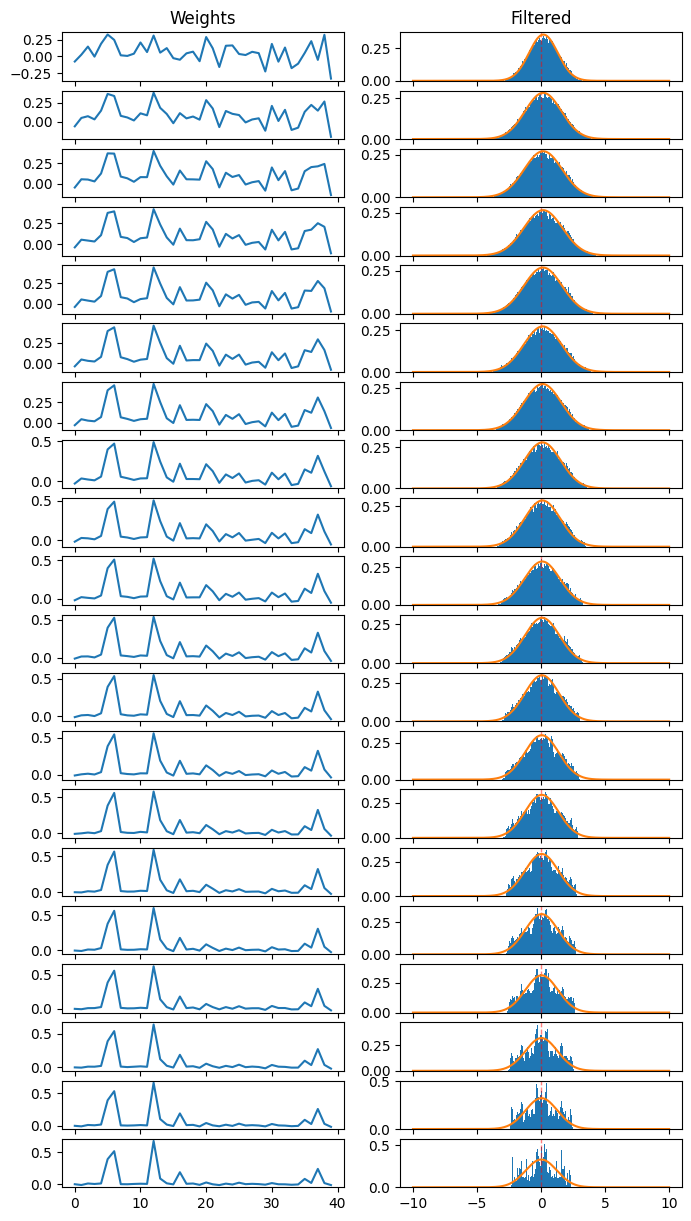

In [43]:
fig, axs = plt.subplots(20, 2, figsize=(8, 15), sharex='col', sharey=False)
for i, (ax1, ax2) in enumerate(axs):
    if i == 0:
        ax1.set_title('Weights')
        ax2.set_title('Filtered')
    
    w = weights[2*i,0]
    w /= jnp.linalg.norm(w)
    ax1.plot(w)
    ax2.hist(xfilt @ w, bins=100, density=True)
    ax2.axvline(0, color='r', linestyle='--', linewidth=1, alpha=0.5)

    m = mui @ w
    s = jnp.sqrt(w @ Sigmai @ w)
    ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

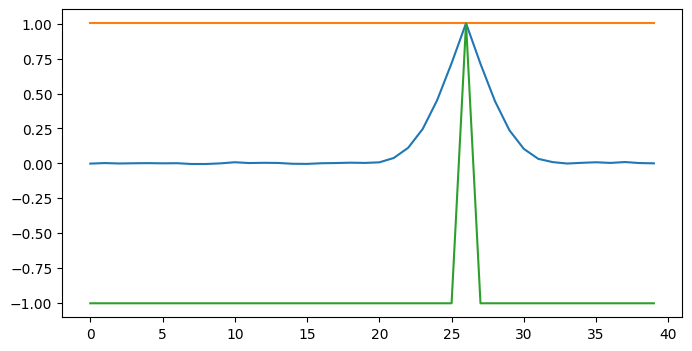

In [38]:
m = jnp.mean(xfilt, axis=0)
alpha = 20
top = jnp.percentile(xfilt, 100 - alpha/2, axis=0)
bot = jnp.percentile(xfilt, alpha/2, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(m, label='Mean')
ax.plot(top, label='97.5th percentile')
ax.plot(bot, label='2.5th percentile')

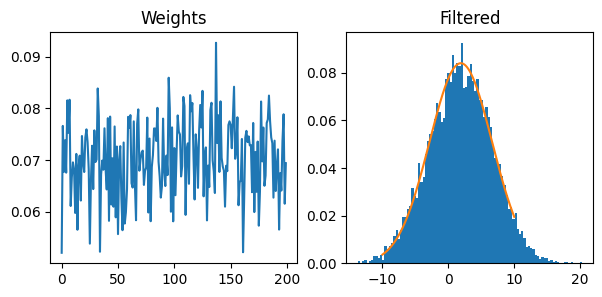

In [42]:
w = jnp.ones(config['num_dimensions']) + 0.1 * jax.random.normal(config['key'], (config['num_dimensions'],))
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

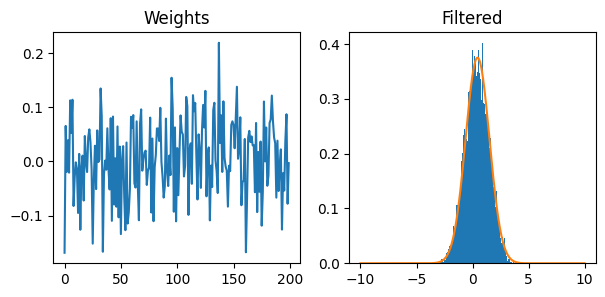

In [43]:
w = jax.random.normal(config['key'], (config['num_dimensions'],))
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

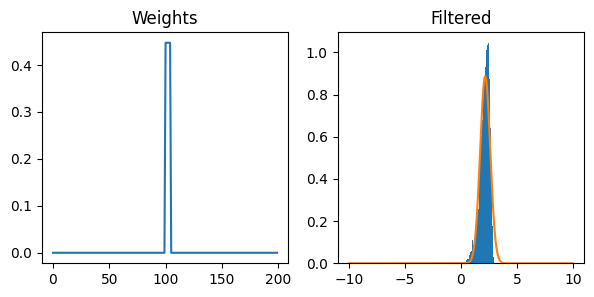

In [38]:
w = jnp.zeros(config['num_dimensions']); w = w.at[100:105].set(1)
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

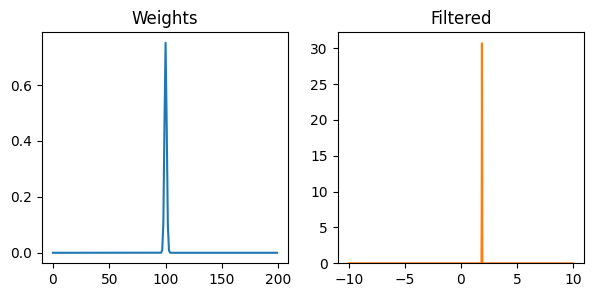

In [44]:
w = jnp.exp(-(jnp.arange(config['num_dimensions']) - 100)**2 / 2)
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

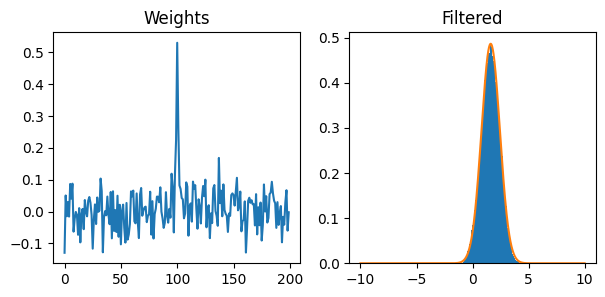

In [48]:
w = 0.1 * jax.random.normal(config['key'], (config['num_dimensions'],)) + jnp.exp(-(jnp.arange(config['num_dimensions']) - 100)**2 / 2)
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

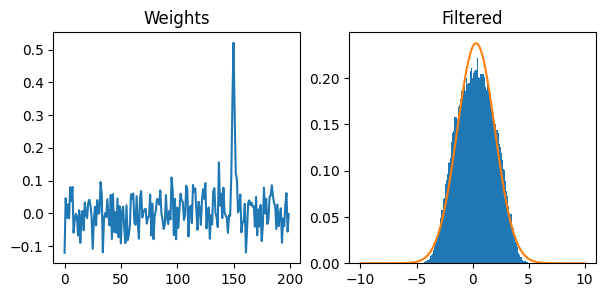

In [49]:
w = 0.1 * jax.random.normal(config['key'], (config['num_dimensions'],)) + 0.01 * jnp.exp(-(jnp.arange(config['num_dimensions']) - 50)**2 / 2) + jnp.exp(-(jnp.arange(config['num_dimensions']) - 150)**2 / 2)
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')

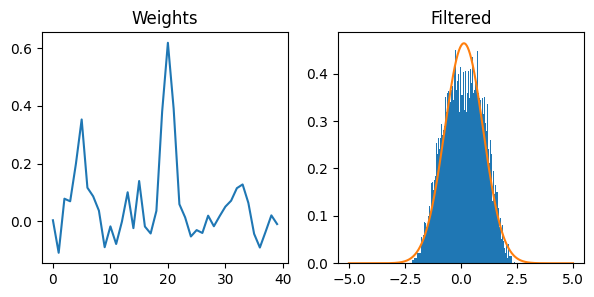

In [87]:
w = 0.1 * jax.random.normal(config['key'], (config['num_dimensions'],)) + jnp.exp(-(jnp.arange(config['num_dimensions']) - 20)**2 / 2) + 0.5 * jnp.exp(-(jnp.arange(config['num_dimensions']) - 5)**2 / 2)
w /= jnp.linalg.norm(w)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(w)
ax1.set_title('Weights')
ax2.hist(xfilt @ w, bins=100, density=True)
ax2.set_title('Filtered')

m = mui @ w
s = jnp.sqrt(w @ Sigmai @ w)
ax2.plot(xp, gaussian_pdf(xp, m, s), label='Gaussian')